In [4]:
#--------------------------------加载第一部分的预处理数据-----------------------------------------------
import os
import pandas as pd
import numpy as np


factors = ['Beta60', 'OperatingRevenueGrowRate', 'NetProfitGrowRate', 'NetCashFlowGrowRate', 'NetProfitGrowRate5Y', 'TVSTD20',
           'TVSTD6', 'TVMA20', 'TVMA6', 'BLEV', 'MLEV', 'CashToCurrentLiability', 'CurrentRatio', 'REC', 'DAREC', 'GREC',
           'DASREV', 'SFY12P', 'LCAP', 'ASSI', 'LFLO', 'TA2EV', 'PEG5Y', 'PE', 'PB', 'PS', 'SalesCostRatio', 'PCF', 'CETOP',
           'TotalProfitGrowRate', 'CTOP', 'MACD', 'DEA', 'DIFF', 'RSI', 'PSY', 'BIAS10', 'ROE', 'ROA', 'ROA5', 'ROE5',
           'DEGM', 'GrossIncomeRatio', 'ROECut', 'NIAPCut', 'CurrentAssetsTRate', 'FixedAssetsTRate', 'FCFF', 'FCFE', 'PLRC6',
           'REVS5', 'REVS10', 'REVS20', 'REVS60', 'HSIGMA', 'HsigmaCNE5', 'ChaikinOscillator', 'ChaikinVolatility', 'Aroon',
           'DDI', 'MTM', 'MTMMA', 'VOL10', 'VOL20', 'VOL5', 'VOL60', 'RealizedVolatility', 'DASTD', 'DDNSR', 'Hurst']

df = pd.read_csv('dataset_1.csv',encoding='GBK')
df.head()

,Unnamed: 0,ticker,tradeDate,Beta60,OperatingRevenueGrowRate,NetProfitGrowRate,NetCashFlowGrowRate,NetProfitGrowRate5Y,TVSTD20,TVSTD6,...,RealizedVolatility,DASTD,DDNSR,Hurst,next_month_end,abs_return,active_return,industryName1,label,year
0,0,1,20070131,-0.838573,-0.527473,2.064908,-0.235434,-0.120729,0.478006,0.268336,...,0.0,-0.603847,-1.160788,0.0,20070228,-0.004221,-0.071021,银行,-1,2007
1,1,2,20070131,0.603209,0.476466,-0.019215,-0.013746,-1.210592,0.762963,0.696981,...,0.0,0.655525,-0.847547,0.0,20070228,-0.037359,-0.104159,房地产,-1,2007
2,2,60,20070131,1.439494,-0.559091,1.508711,0.085016,1.423780,2.340842,1.987375,...,0.0,0.747250,0.638908,0.0,20070228,0.171481,0.104681,有色金属,0,2007
3,3,63,20070131,-0.221436,-0.891169,-0.690564,1.331827,0.033096,1.378065,0.707162,...,0.0,-0.694765,-0.580936,0.0,20070228,0.093903,0.027103,通信,0,2007
4,4,69,20070131,-0.882542,0.101637,-0.671414,0.191923,0.463894,2.255643,1.680278,...,0.0,0.640970,0.450284,0.0,20070228,0.020656,-0.046144,房地产,-1,2007


In [5]:
#--------------------------------模型训练、验证、测试阶段-----------------------------------------------

import time

def get_train_val_test_data(df, year):
    back_year = max(2007, year-6)
    train_df = df[(df['year']>=back_year) & (df['year']<year)]
    
    test_df = df[df['year']==year]
    
    return train_df, test_df


def format_feature_label(origin_df, is_filter=True):
    if is_filter:
        origin_df = origin_df[origin_df['label']!=0]
        #模型的label输入范围替换成[0, 1]，比较直观，需要对原始label进行替换
        origin_df['label'] = origin_df['label'].replace(-1, 0)
        
    feature = np.array(origin_df[factors])
    label = np.array(origin_df['label'])

    return feature, label

def write_factor_to_csv(df, predict_score, year, filename):  
    df.loc[:,'factor'] = predict_score
    df = df.loc[:, ['ticker', 'tradeDate', 'label', 'factor']]
    is_header = True
    if year != 2011:
        is_header = False
    
    df.to_csv(filename, mode='a+', encoding='utf-8', header=is_header)


In [12]:
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

def get_lr_result(train_data, train_label, test_data): # model 1
    linear_model = LogisticRegression()
    linear_model.fit(train_data, train_label)
    predict_score = linear_model.predict_proba(test_data)[:, 1]   
    return predict_score

def get_svm_result(train_data, train_label, test_data): #model 2
    svm = SVC(probability=True)
    svm.fit(train_data, train_label)
    predict_score = svm.predict(test_data)[:,1]
    return predict_score

def get_sgd_result(train_data, train_label, test_data): #model 3
    sgd = SGDClassifier(loss = 'log')
    sgd.fit(train_data, train_label)
    predict_score = sgd.predict_proba(test_data)[:, 1]   
    return predict_score

def get_rf_result(train_data, train_label, test_data): #model 4
    rf = RandomForestClassifier(n_estimators = 100,min_samples_split = 50,min_samples_leaf =10，n_jods = 4)
    rf.fit(train_data, train_label)
    predict_score = rf.predict_proba(test_data)[:, 1]   
    return predict_score

def pipeline(model):
    '''
    对7个阶段分别进行训练测试，并保存测试的因子合成值
    返回:
        boost_model_list, list结构，每个阶段汇总的模型集合
    '''
    t0 = time.time()
    linear_file = "factor_linear_%d.csv"%model
    
    for year in range(2011, 2018):
        print('training model for %s' % year)
        t1 = time.time()
        #构建训练测试数据
        train_df, test_df = get_train_val_test_data(df, year)
        train_feature, train_label = format_feature_label(train_df)
        test_feature, test_label = format_feature_label(test_df, False)

        if model == 1:
            predict_score = get_lr_result(train_feature, train_label, test_feature)
        if model == 2:
            predict_score = get_svm_result(train_feature, train_label, test_feature)
        if model == 3:
            predict_score = get_sgd_result(train_feature, train_label, test_feature)
        if model == 4:
            predict_score = get_rf_result(train_feature, train_label, test_feature)
            
        write_factor_to_csv(test_df, predict_score, year, linear_file)

        print('------------------ finish year: %s, time cost: %s seconds--------------' % (year, time.time() - t1))

    print('Done, Time cost: %s seconds' % (time.time() - t0))
        
pipeline(4)

training model for 2011


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

------------------ finish year: 2011, time cost: 46.86828398704529 seconds--------------
training model for 2012


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

------------------ finish year: 2012, time cost: 66.96408438682556 seconds--------------
training model for 2013


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

------------------ finish year: 2013, time cost: 89.07803392410278 seconds--------------
training model for 2014


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

------------------ finish year: 2014, time cost: 97.94631719589233 seconds--------------
training model for 2015


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

------------------ finish year: 2015, time cost: 105.39398741722107 seconds--------------
training model for 2016


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


------------------ finish year: 2016, time cost: 109.46835160255432 seconds--------------
training model for 2017


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


------------------ finish year: 2017, time cost: 115.0523955821991 seconds--------------
Done, Time cost: 630.7724661827087 seconds


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
def get_sgd_result(train_data, train_label, test_data): #model 3
    sgd = SGDClassifier(loss = 'log')
    sgd.fit(train_data, train_label)
    predict_score = sgd.predict_proba(test_data)[:, 1]   
    return predict_score

pipeline(3)

training model for 2011


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of

------------------ finish year: 2011, time cost: 0.3724827766418457 seconds--------------
training model for 2012
------------------ finish year: 2012, time cost: 0.318997859954834 seconds--------------
training model for 2013
------------------ finish year: 2013, time cost: 0.3337438106536865 seconds--------------
training model for 2014
------------------ finish year: 2014, time cost: 0.3398277759552002 seconds--------------
training model for 2015
------------------ finish year: 2015, time cost: 0.35972094535827637 seconds--------------
training model for 2016
------------------ finish year: 2016, time cost: 0.37299346923828125 seconds--------------
training model for 2017
------------------ finish year: 2017, time cost: 0.3792531490325928 seconds--------------
Done, Time cost: 2.4779534339904785 seconds


In [16]:
def get_svm_result(train_data, train_label, test_data): #model 2
    svm = SVC(probability=True)
    svm.fit(train_data, train_label)
    predict_score = svm.predict_proba(test_data)[:,1]
    return predict_score
pipeline(2)

training model for 2011


/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

------------------ finish year: 2011, time cost: 155.40050745010376 seconds--------------
training model for 2012
------------------ finish year: 2012, time cost: 427.3472406864166 seconds--------------
training model for 2013
------------------ finish year: 2013, time cost: 886.9392981529236 seconds--------------
training model for 2014
------------------ finish year: 2014, time cost: 1109.3214716911316 seconds--------------
training model for 2015
------------------ finish year: 2015, time cost: 1266.5751221179962 seconds--------------
training model for 2016
------------------ finish year: 2016, time cost: 1486.8610155582428 seconds--------------
training model for 2017
------------------ finish year: 2017, time cost: 1662.3736753463745 seconds--------------
Done, Time cost: 6994.819190263748 seconds


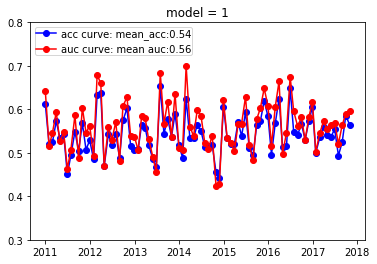

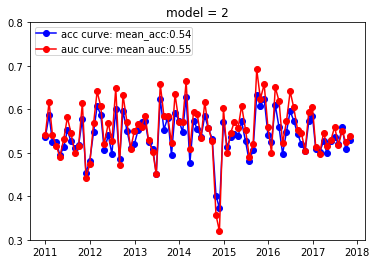

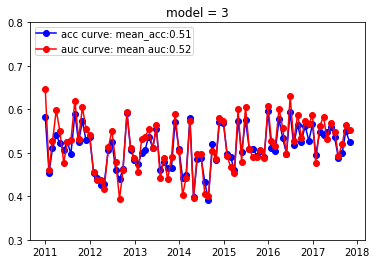

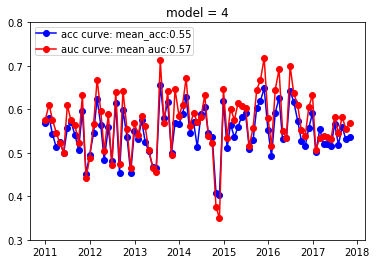

In [30]:
from datetime import datetime
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


def get_test_auc_acc(filename):
    '''
    计算二分类模型样本外的ACC与AUC，按照日期统计
    返回:
        acc_list: 样本外的预测准确率集合
        auc_list: 样本外的预测AUC集合
        mean_acc: 样本外的平均预测准确率
        mean_auc: 样本外的平均预测AUC
    '''
    
    df = pd.read_csv(filename)
    #只查看原有label为+1, -1的数据
    df = df[df['label'] != 0]
    df.loc[:, 'predict'] = df.loc[:, 'factor'].apply(lambda x : 1 if x > 0.5 else -1)
    
    acc_list = []  #保存每个月份的准确率
    auc_list = []  #保存每个月份的AUC指标
    for date, group in df.groupby('tradeDate'):
        df_correct = group[group['predict'] == group['label']]
        correct = len(df_correct) * 1.0 / len(group)
        auc =  roc_auc_score(np.array(group['label']), np.array(group['factor']))
        acc_list.append([date, correct])
        auc_list.append([date, auc])
        
    acc_list = sorted(acc_list, key=lambda x: x[0], reverse=False)
    mean_acc = sum([item[1] for item in acc_list]) / len(acc_list)
    
    auc_list = sorted(auc_list, key=lambda x: x[0], reverse=False)
    mean_auc = sum([item[1] for item in auc_list]) / len(auc_list)
    
    return acc_list, auc_list, round(mean_acc, 2), round(mean_auc, 2)

def plot_accuracy_curve(filename):
    '''
    画图
    '''
    acc_list, auc_list, mean_acc, mean_auc = get_test_auc_acc(filename)

    plt.plot([datetime.strptime(str(item[0]), '%Y%m%d') for item in acc_list], [item[1] for item in acc_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y%m%d') for item in auc_list], [item[1] for item in auc_list], '-ro')

    plt.legend([u"acc curve: mean_acc:%s"%mean_acc, u"auc curve: mean auc:%s"%mean_auc], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((0.3, 0.8))

for i in range(1,5):
    plot_accuracy_curve( "factor_linear_%d.csv"%i)
    plt.title('model = %d'%i)
    plt.show()